In [1]:
import json
import os


import rootpath
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Circle
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import geopandas as gpd
import pycountry as pc
import pycountry_convert as pcc


from lhledge import cfgLoader
from lhledge import lhlFilters
from lhledge import compass
from lhledge import loadGeographicData

In [2]:
CYCLE = 10020
DATE = 20220501
# CYCLE = 8820
# DATE = 20201002
# CYCLE = 4578
# DATE = 20160302
# DOWNSAMPLING = 10
DOWNSAMPLING = 1

In [3]:
# Change directory to run from the root dir of the project
path = rootpath.detect(pattern=".git")
os.chdir(path)

# load config file
cfg = cfgLoader.cfgLoader("config.yml")

In [4]:
concat_df = pd.read_csv(f"data/processed/snapshots/{CYCLE}.csv.gz", compression="gzip")

In [5]:
concat_df

,near_side_cc,far_side_cc,near_node_id,far_node_id,near_side_lat,far_side_lat,near_side_lon,far_side_lon,near_node_asn,far_node_asn,mpls_tunnel,diff_rtt,dist
0,AE,CH,581886,202038,25.26330,47.43480,55.30870,8.56290,20940,20940,False,114.876,4407.826551
1,AE,DE,97995,28880,24.00000,50.11552,54.00000,8.68417,8966,35753,False,67.622,4266.720006
2,AE,DE,201421,201167,24.00000,50.11880,54.00000,8.68430,8966,20940,False,111.747,4266.720006
3,AE,DE,2821454,2821456,25.11750,50.11880,56.33460,8.68430,21859,21859,False,110.492,4266.720006
4,AE,ES,2627,28862,25.06570,40.41630,55.17128,-3.69340,15412,33788,False,137.069,4853.427698
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156128,ZA,US,789700,16677,-26.20227,37.75100,28.04363,-97.82200,3491,3491,False,227.185,11927.189936
156129,ZA,US,1916540,78885070,-26.20227,45.59990,28.04363,-121.18710,15169,15169,False,283.130,11927.189936
156130,ZA,US,2803516,11867,-26.20227,37.75100,28.04363,-97.82200,8075,8075,False,261.883,11927.189936
156131,ZA,US,4571256,599,-29.00000,37.80923,24.00000,-85.46690,3741,3741,True,164.920,11927.189936


In [6]:
thetas = compass.find_fine_grained_angle(concat_df)

thetas.head()

,node1,node2,cc1,cc2,theta
0,581886,202038,AE,CH,-0.442876
1,202038,581886,CH,AE,-0.442876
2,202038,571926,CH,JP,-0.089335
3,202038,573431,CH,JP,-0.100075
4,97995,28880,AE,DE,-0.522811


In [8]:
def cc2cont(cc):
    try:
        country = pc.countries.get(alpha_2=cc)
        continent = pcc.country_alpha2_to_continent_code(country.alpha_2)
        return continent
    except:
        return ""

In [9]:
thetas["cont1"] = thetas["cc1"].map(cc2cont)
thetas["cont2"] = thetas["cc2"].map(cc2cont)

In [10]:
thetas.head()

,node1,node2,cc1,cc2,theta,cont1,cont2
0,581886,202038,AE,CH,-0.442876,AS,EU
1,202038,581886,CH,AE,-0.442876,EU,AS
2,202038,571926,CH,JP,-0.089335,EU,AS
3,202038,573431,CH,JP,-0.100075,EU,AS
4,97995,28880,AE,DE,-0.522811,AS,EU


In [13]:
scn = pd.read_csv("data/processed/scn/scn_theta.csv")

In [14]:
scn.head()

,cable_name,from_city,from_country,from_continent,from_lat,from_lon,to_city,to_country,to_continent,to_lat,to_lon,theta
0,med-cable-network,Algiers,Algeria,AF,36.765730,3.031890,Marseille,France,EU,43.293579,5.372507,-1.915075
1,med-cable-network,Annaba,Algeria,AF,36.902344,7.755440,Marseille,France,EU,43.293579,5.372507,-1.213917
2,med-cable-network,Marseille,France,EU,43.293579,5.372507,Algiers,Algeria,AF,36.765730,3.031890,1.226517
3,med-cable-network,Marseille,France,EU,43.293579,5.372507,Annaba,Algeria,AF,36.902344,7.755440,1.927675
4,medusa-submarine-cable-system,Algiers,Algeria,AF,36.765730,3.031890,Marseille,France,EU,43.293579,5.372507,-1.915075


In [15]:
def _draw_compass_3x2_double(s, cycle, ax, color, label):
    vals, intervals = np.histogram(s, bins=60)

    max_val = max(vals)

    x_list = []
    y_list = []
    for i in range(0, len(intervals) - 1):
        theta = (intervals[i + 1] + intervals[i]) / 2.0
        x = np.cos(theta)
        y = np.sin(theta)
        x_list.append((vals[i] * x) / max_val)
        y_list.append((vals[i] * y) / max_val)

    x_list = np.array(x_list)
    y_list = np.array(y_list)

    for r in np.arange(0.1, 1.01, 0.1)[::-1]:
        drawObject = Circle((0, 0), radius=r,
                            fill=False, color="#aeaeae",
                            linestyle="dashed")
        ax.add_patch(drawObject)


    for theta in np.linspace(-np.pi, np.pi, 13):
        x = np.cos(theta)
        y = np.sin(theta)
        ax.plot([0, x], [0, y], color="#aeaeae", linestyle="dashed")
    
    p = []
    for i in range(len(x_list) - 1):
        ax.plot([x_list[i], x_list[i + 1]],
                [y_list[i], y_list[i + 1]],
                color="black",
                marker="o")
        p.append([x_list[i], y_list[i]])
        
    p.append([x_list[-1], y_list[-1]])

    ax.plot([x_list[i + 1], x_list[0]],
            [y_list[i + 1], y_list[0]],
            color="black",
            marker="o")

    polygon = Polygon(p, True, facecolor=color, label=label)
    ax.add_patch(polygon)
    
    coordinates = {
        "E": (1, 0),
        "ENE": (np.cos((1 / 6) * np.pi), np.sin((1 / 6) * np.pi)),
        "NNE": (np.cos((2 / 6) * np.pi), np.sin((2 / 6) * np.pi)),
        "N": (0, 1),
        "NNW": (np.cos((4 / 6) * np.pi), np.sin((4 / 6) * np.pi)),
        "WNW": (np.cos((5 / 6) * np.pi), np.sin((5 / 6) * np.pi)),
        "W": (-1, 0),
        "S": (0, -1),
        "ESE": (np.cos(-(1 / 6) * np.pi), np.sin(-(1 / 6) * np.pi)),
        "SSE": (np.cos(-(2 / 6) * np.pi), np.sin(-(2 / 6) * np.pi)),
        "SSW": (np.cos(-(4 / 6) * np.pi), np.sin(-(4 / 6) * np.pi)),
        "WSW": (np.cos(-(5 / 6) * np.pi), np.sin(-(5 / 6) * np.pi)),
    }

    for c in coordinates:
        ax.annotate(
            f"{c}",
            coordinates[c],
            fontsize=16,
            color="black",
            va='center',
            ha='center'
        )

    ax.set_title(cycle, fontsize=25)
    ax.axis('off')

def draw_compass_3x2_double(s, t, cycle, ax):
    _draw_compass_3x2_double(t, cycle, ax, "blue", "SCN")
    _s = np.append(s, s - np.pi)
    _draw_compass_3x2_double(_s, cycle, ax, "red", "LHL")

In [16]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/tmp/ipykernel_451548/3270548944.py:45: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = Polygon(p, True, facecolor=color, label=label)
/tmp/ipykernel_451548/3270548944.py:12: RuntimeWarning: invalid value encountered in scalar divide
  x_list.append((vals[i] * x) / max_val)
/tmp/ipykernel_451548/3270548944.py:13: RuntimeWarning: invalid value encountered in scalar divide
  y_list.append((vals[i] * y) / max_val)


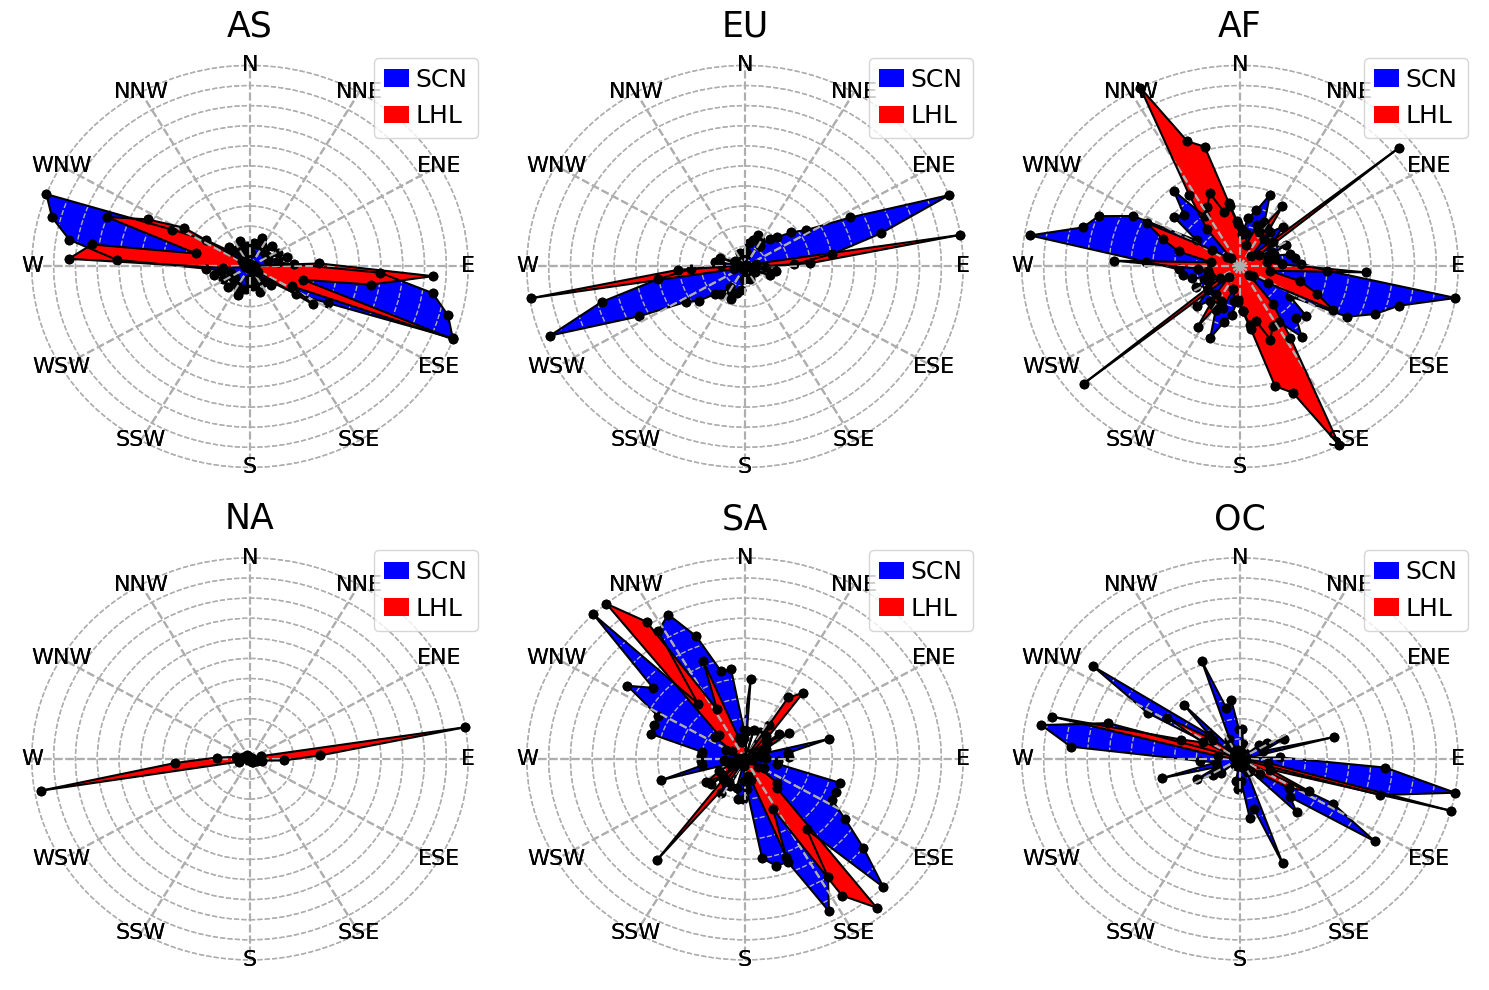

In [17]:
fig, _ax = plt.subplots(2, 3, figsize=(15, 10))

i = 0
for cont in thetas.drop_duplicates("cont1")["cont1"].values:
    ax = _ax[int(i / 3)][i % 3]
    
    if cont == "EU":
        draw_compass_3x2_double(
            thetas.loc[(thetas["cont1"] == cont) | (thetas["cont2"] == cont)]["theta"].values, 
            (-1) * scn.loc[(scn["from_continent"] == cont) | (scn["to_continent"] == cont)]["theta"].values, 
            cont, ax)
    else:
        draw_compass_3x2_double(
            thetas.loc[(thetas["cont1"] == cont) | (thetas["cont2"] == cont)]["theta"].values, 
            scn.loc[(scn["from_continent"] == cont) | (scn["to_continent"] == cont)]["theta"].values, 
            cont, ax)
    
    ax.legend(loc='upper right', ncol=1, frameon=True, fontsize=18,
          handletextpad=0.25, columnspacing=0.5, handlelength=1)
    
    i += 1

fig.subplots_adjust(hspace=0)
fig.tight_layout()
# fig.savefig(f"figures/lhls/compass_v2_conts_scn_vs_lhl.pdf")

In [18]:
def draw_compass_double(s, cycle, ax, color, label):
    # vals, intervals = np.histogram(np.append(s, s - np.pi), bins=20)
    vals, intervals = np.histogram(s, bins=20)

    max_val = max(vals)
    
    # print(max_val / (sum(vals) - max_val))

    x_list = []
    y_list = []
    for i in range(0, len(intervals) - 1):
        theta = (intervals[i + 1] + intervals[i]) / 2.0
        x = np.cos(theta)
        y = np.sin(theta)
        x_list.append((vals[i] * x) / max_val)
        y_list.append((vals[i] * y) / max_val)

    x_list = np.array(x_list)
    y_list = np.array(y_list)

    for r in np.arange(0.1, 1.01, 0.1)[::-1]:
        drawObject = Circle((0, 0), radius=r,
                            fill=False, color="#aeaeae",
                            linestyle="dashed")
        ax.add_patch(drawObject)


    for theta in np.linspace(-np.pi, np.pi, 13):
        x = np.cos(theta)
        y = np.sin(theta)
        ax.plot([0, x], [0, y], color="#aeaeae", linestyle="dashed")
    
    p = []
    for i in range(len(x_list) - 1):
        # ax.plot([x_list[i], x_list[i + 1]],
        #         [y_list[i], y_list[i + 1]],
        #         color="black",
        #         marker="o")
        p.append([x_list[i], y_list[i]])
        
    p.append([x_list[-1], y_list[-1]])

    # ax.plot([x_list[i + 1], x_list[0]],
    #         [y_list[i + 1], y_list[0]],
    #         color="black",
    #         marker="o")

    polygon = Polygon(p, True, edgecolor="black", facecolor=color, label=label)
    ax.add_patch(polygon)
    
    coordinates = {
        "E": (1, 0),
        "ENE": (np.cos((1 / 6) * np.pi), np.sin((1 / 6) * np.pi)),
        "NNE": (np.cos((2 / 6) * np.pi), np.sin((2 / 6) * np.pi)),
        "N": (0, 1),
        "NNW": (np.cos((4 / 6) * np.pi), np.sin((4 / 6) * np.pi)),
        "WNW": (np.cos((5 / 6) * np.pi), np.sin((5 / 6) * np.pi)),
        "W": (-1, 0),
        "S": (0, -1),
        "ESE": (np.cos(-(1 / 6) * np.pi), np.sin(-(1 / 6) * np.pi)),
        "SSE": (np.cos(-(2 / 6) * np.pi), np.sin(-(2 / 6) * np.pi)),
        "SSW": (np.cos(-(4 / 6) * np.pi), np.sin(-(4 / 6) * np.pi)),
        "WSW": (np.cos(-(5 / 6) * np.pi), np.sin(-(5 / 6) * np.pi)),
    }

    for c in coordinates:
        ax.annotate(
            f"{c}",
            coordinates[c],
            fontsize=16,
            color="black",
            va='center',
            ha='center'
        )

    ax.set_title(cycle, fontsize=25)
    ax.axis('off')



/tmp/ipykernel_451548/3555227752.py:48: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = Polygon(p, True, edgecolor="black", facecolor=color, label=label)


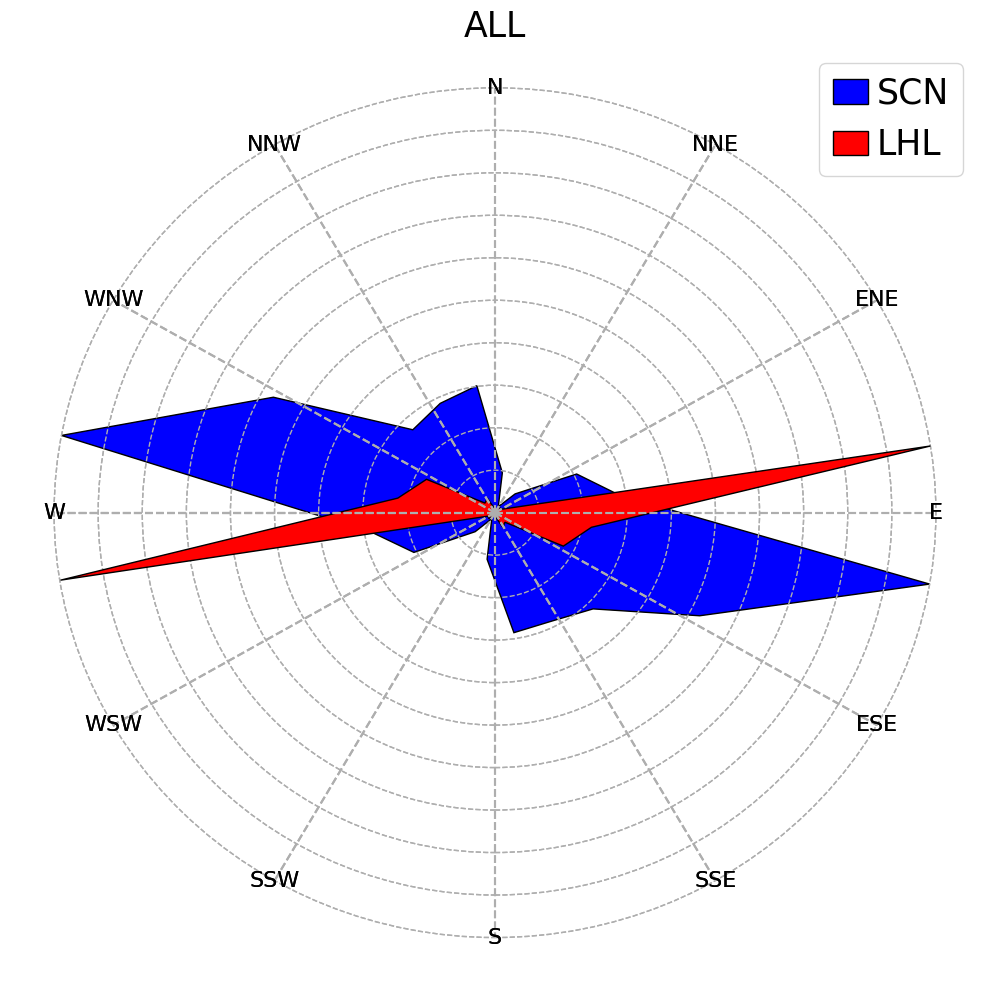

In [19]:
fig, ax = plt.subplots(1, figsize=(10, 10))

draw_compass_double(scn.loc[(scn["from_continent"] == cont) | (scn["to_continent"] == cont)]["theta"].values, 
                    "ALL", ax, "blue", "SCN")

x = np.append(thetas["theta"].values, thetas["theta"].values - np.pi)
draw_compass_double(x, "ALL", ax, "red", "LHL")

ax.legend(loc='upper right', ncol=1, frameon=True, fontsize=25,
          handletextpad=0.25, columnspacing=0.5, handlelength=1)

fig.subplots_adjust(hspace=0)
fig.tight_layout()
# fig.savefig(f"figures/lhls/compass_v2_{cycle}_scn_vs_lhl.pdf")
